# **The whole is based on:**
### https://github.com/openai/gpt-2-output-dataset/tree/master/detector
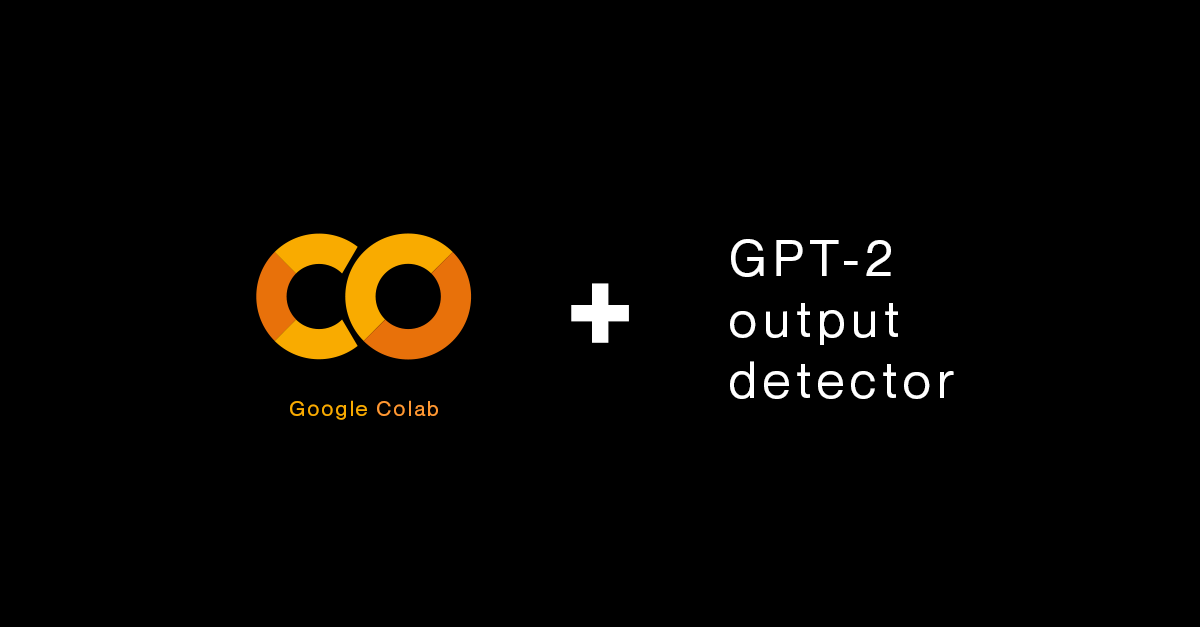

# **Install the Libraries**

In [ ]:
!pip install gradio transformers
!pip install onnx onnxruntime
# !pip install sentencepiece sentence-splitter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.8 MB/s eta 0:00

# **Link for the optimized ONNX model**

https://drive.google.com/file/d/1XpOj-fQskrkaNtc0ftjs4cj3uHqk0IJk/view?usp=sharing

# **Import Libraries**

In [ ]:
import os, sys
import gradio as gr
import numpy as np

from transformers import RobertaForSequenceClassification, RobertaTokenizer
import json, time
import onnx
import onnxruntime
# import fire
import torch

# **Download the weights of detector model**

##### https://openaipublic.azureedge.net/gpt-2/detector-models/v1/detector-large.pt

##### https://openaipublic.azureedge.net/gpt-2/detector-models/v1/detector-base.pt

In [ ]:
!wget https://openaipublic.azureedge.net/gpt-2/detector-models/v1/detector-large.pt
# !wget https://openaipublic.azureedge.net/gpt-2/detector-models/v1/detector-base.pt

--2023-07-07 16:01:58--  https://openaipublic.azureedge.net/gpt-2/detector-models/v1/detector-large.pt
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.70, 13.107.213.70, 2620:1ec:bdf::70, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1425743818 (1.3G) [application/octet-stream]
Saving to: ‘detector-large.pt’

detector-large.pt   100%[===================>]   1.33G  13.8MB/s    in 1m 48s  

2023-07-07 16:03:46 (12.6 MB/s) - ‘detector-large.pt’ saved [1425743818/1425743818]



### **For getting satisfied result, use "*detector-large.pt*" checkpoint**

In [ ]:
checkpoint = 'detector-large.pt'
# checkpoint = 'detector-base.pt'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data = torch.load(checkpoint, map_location='cpu')

model_name = 'roberta-large' #if data['args']['large'] else 'roberta-base'
#model_name = 'roberta-base'
model = RobertaForSequenceClassification.from_pretrained(model_name)
tokenizer = RobertaTokenizer.from_pretrained(model_name)
roberta_model = model.to('cpu')
roberta_model.load_state_dict(data['model_state_dict'], strict=False)
roberta_model.eval()

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should 

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [ ]:
query = """Write a list of the names of video games that have been released over the last 10 years.

In the above paragraph, you can see that I know nothing about “the last 10 years” except the fact that they are over 10 years. Please also note that I put in a space next to my name to indicate that I know nothing about the last 10 years, since that is the only information I had to work with.

The output I obtained looked like:

My challenge was to make a program that could generate a list of all the names of all video games that have been released in the last 10 years.

If you have a basic understanding of VB.NET as well as the following:

There is a “File” module. You can add a file by navigating to the module, and doing File.Add("filename")

Then, add an “Instance” attribute. You can add an instance of an object based on a given filename by navigating to the module, and doing Instance.Add(filename)

Once there, you can navigate to the module, and do Module.GetType("instance"). It will print out all the type names. The class names should be in the “Implements” section."""

print(query)

Write a list of the names of video games that have been released over the last 10 years.

In the above paragraph, you can see that I know nothing about “the last 10 years” except the fact that they are over 10 years. Please also note that I put in a space next to my name to indicate that I know nothing about the last 10 years, since that is the only information I had to work with.

The output I obtained looked like:

My challenge was to make a program that could generate a list of all the names of all video games that have been released in the last 10 years.

If you have a basic understanding of VB.NET as well as the following:

There is a “File” module. You can add a file by navigating to the module, and doing File.Add("filename")

Then, add an “Instance” attribute. You can add an instance of an object based on a given filename by navigating to the module, and doing Instance.Add(filename)

Once there, you can navigate to the module, and do Module.GetType("instance"). It will print out

In [ ]:
query = """The last business trip  I drove to San Francisco  I went to Hertz Rentals and got a 1999 Ford Taurus  thinking it looked comfortable and professional  I found the seating to be uncomfortable for myself  as well as for my passenger Now  seating comfort may not be important to you  but it is to me The fuel usage was fine  the car did get us there with no problems  but  it was such an uncomfortable ride for both of us  It is not as though I am hard to fit into a car  I am 5 5  weigh 115 pounds  and I am usually quite comfortable in most any car  But  the Taurus seemed especially uncomfortable  For anyone who is thinking of renting a car for a long trip  I would suggest that the Ford Taurus  1999  not be on the list of  be sure to get this There was a large trunk that allowed us to pack a lot of materials needed for the business end of the trip  Driving it was a breeze  and everything  worked  right  I have no complaints about the standard making of the car  except in the comfort area  How important is comfort to you  On a long trip  being an uncomfortable driver is distracting to me  and it made the trip seem unnecessarily longer than it should have felt  I make this trip a lot  The Saturn would have been a better choice for me  as I have rented this model quite often  It offers comforts that the Taurus simply does not have If you are planning a long trip  or to buy a car that you intend to be comfortably seated in  check out the Taurus on a longer trial basis than you might another car  You may find the same thing happening to your comfort"""
query

'The last business trip  I drove to San Francisco  I went to Hertz Rentals and got a 1999 Ford Taurus  thinking it looked comfortable and professional  I found the seating to be uncomfortable for myself  as well as for my passenger Now  seating comfort may not be important to you  but it is to me The fuel usage was fine  the car did get us there with no problems  but  it was such an uncomfortable ride for both of us  It is not as though I am hard to fit into a car  I am 5 5  weigh 115 pounds  and I am usually quite comfortable in most any car  But  the Taurus seemed especially uncomfortable  For anyone who is thinking of renting a car for a long trip  I would suggest that the Ford Taurus  1999  not be on the list of  be sure to get this There was a large trunk that allowed us to pack a lot of materials needed for the business end of the trip  Driving it was a breeze  and everything  worked  right  I have no complaints about the standard making of the car  except in the comfort area  Ho

# **Converting the model to ONNX format for optimizing the model**

In [ ]:
# tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
input_ids = torch.tensor(tokenizer.encode(query, add_special_tokens=True)).unsqueeze(0)  # Batch size 1
os.makedirs('/content/gpt2-detector/', exist_ok=True)
ONNX_path = "/content/gpt2-detector/roberta_detector.onnx"
torch.onnx.export(roberta_model,
                  (input_ids),
                  ONNX_path,
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes={'input' :{0 : 'batch_size',
                                          1: 'sentence_length'},
                                'output': {0: 'batch_size'}})

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



# **Function to get the output whether the text is generated by human or not.**

In [ ]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# correct solution:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=-1) # only difference

In [ ]:
def gpt_detector(query, onnx_path= ONNX_path):
    # if model_format == 'roberta-onnx':
    start = time.time()
    total_words = len(query.split())
    model_name = 'roberta-large'
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    ort_session = onnxruntime.InferenceSession(onnx_path)
    tokens_onnx = tokenizer.encode(query)
    all_tokens = len(tokens_onnx)
    tokens_onnx = tokens_onnx[:tokenizer.model_max_length - 2]
    used_tokens = len(tokens_onnx)
    input_ids_o = torch.tensor([tokenizer.bos_token_id] + tokens_onnx + [tokenizer.eos_token_id]).unsqueeze(0)
    mask = torch.ones_like(input_ids_o)


    # input_ids_o = torch.tensor().unsqueeze(0)  # Batch size 1
    # compute ONNX Runtime output prediction
    # ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(input_ids_o)}
    # ort_out = ort_session.run(None, ort_inputs)
    with torch.no_grad():
        ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(input_ids_o)}
        logits_onnx = ort_session.run(None, ort_inputs)
        # logits = model(tokens.to(device), attention_mask=mask.to(device))[0]
        probs_onnx = softmax(logits_onnx[0])
        end = time.time()
    total_time = np.round(end - start, decimals=2)
    fake_onnx, real_onnx = probs_onnx[0][0], probs_onnx[0][1]
    fake_onnx = np.round(fake_onnx*100, decimals=2)
    real_onnx = np.round(real_onnx*100, decimals=2)
    return fake_onnx, real_onnx




#### **Description that will appear on Gradio UI.**

In [ ]:
ui_description = "Optimizing the GPT-2 Output Detector to the ONNX format is a significant achievement as it allows for improved efficiency, portability, and interoperability of the model. The ONNX format is a popular open standard for representing deep learning models, enabling seamless integration with various AI frameworks and deployment platforms. The purpose of the GPT-2 Output Detector is to identify and filter out problematic outputs generated by the GPT-2 model. This project typically involves fine-tuning the GPT-2 model using techniques like transfer learning or domain-specific training data to make it more reliable and suitable for specific applications or domains."

### **Creating a UI with the help of gradio**

#### **To know more about gradio:**
### **Set debug=True in gpt2_plag(debug=True) for getting runtime error**
#### https://gradio.app/

In [ ]:
# from keras.backend import placeholder
app_inputs = [gr.inputs.Textbox(lines=15, placeholder='Input some text...')]
gpt2_plag = gr.Interface(fn= gpt_detector, inputs=app_inputs, outputs=[gr.outputs.Textbox(label='Fake Weightage'), gr.outputs.Textbox(label='Real Weightage')],
                         title= 'GPT-2 Output Detector', description=ui_description)
gpt2_plag.launch(debug=True, share=True)

<ipython-input-12-9203ff14d55f>:2: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  app_inputs = [gr.inputs.Textbox(lines=15, placeholder='Input some text...')]
<ipython-input-12-9203ff14d55f>:2: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  app_inputs = [gr.inputs.Textbox(lines=15, placeholder='Input some text...')]
<ipython-input-12-9203ff14d55f>:2: GradioDeprecationWarning: `numeric` parameter is deprecated, and it has no effect
  app_inputs = [gr.inputs.Textbox(lines=15, placeholder='Input some text...')]
<ipython-input-12-9203ff14d55f>:3: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  gpt2_plag = gr.Interface(fn= gpt_detector, inputs=app_inputs, outputs=[gr.outputs.Textbox(label='Fake Weightage'), gr.outputs.Textbox(label=

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://38a7f7dd811e4b86fe.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Token indices sequence length is longer than the specified maximum sequence length for this model (645 > 512). Running this sequence through the model will result in indexing errors
